In [44]:
import json
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
from dvclive.keras import DVCLiveCallback

# Loading Data & Pre-processing

In [18]:
text = ''
with open('Cell_Phones_and_Accessories_5.json', 'r') as file:
    text = file.read()

In [19]:
new_text = text.replace('\n', ',\n')
new_text = new_text.strip(',\n')
new_text = f'[{new_text}]'
parsed_text = json.loads(new_text)
parsed_text[0]

{'reviewerID': 'A30TL5EWN6DFXT',
 'asin': '120401325X',
 'reviewerName': 'christina',
 'helpful': [0, 0],
 'reviewText': "They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again",
 'overall': 4.0,
 'summary': 'Looks Good',
 'unixReviewTime': 1400630400,
 'reviewTime': '05 21, 2014'}

In [40]:
X = []
y = []

for item in parsed_text:
    X.append(item['reviewText'])
    y.append(1 if item['overall'] > 3 else 0)

len(X), len(y)

(194439, 194439)

In [41]:
tokenizer = Tokenizer(oov_token= 'OOV')

tokenizer.fit_on_texts(X)
len(tokenizer.word_index)

92128

In [42]:
# Finding max sequence langth
lengths = [len(sequence.split(' ')) for sequence in X]
avg_length = sum(lengths) / len(lengths)
avg_length

92.99432212673383

In [43]:
X = tokenizer.texts_to_sequences(X)
max_length = 110
X = pad_sequences(X, padding= 'post', maxlen= max_length, truncating='post')

KeyboardInterrupt: 

In [ ]:
X[100]

array([42072,     4,   169,   117,    49,   242,    63,   113,  5959,
          25,    18,  1126,   892,     2,    85,    11,     4,     3,
         111,   113,    10,    79,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [ ]:
y = np.array(y, dtype= np.int32)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.9, shuffle= True)

In [ ]:
X_train.shape, y_train.shape

((174995, 120), (174995,))

# Creating and Training Model

In [ ]:
num_labels = len(tokenizer.word_index)
epochs = 20

In [ ]:
model = Sequential([
    Embedding(num_labels, 100, input_length= max_length),
    Bidirectional(LSTM(128)),
    Dropout(0.4),
    Dense(units= 1, activation= 'sigmoid')
])

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 100)          9212800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 9,447,553
Trainable params: 9,447,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint(filepath= 'model.h5', monitor='val_loss', save_best_only= True, save_weights_only=False, mode= 'min', save_freq='epoch', verbose=1)
earlyStopping = EarlyStopping(monitor='val_loss', mode= 'min', patience=2, verbose=1)
dvcCallback = DVCLiveCallback()
history = model.fit(X_train, y_train, epochs= epochs, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint, earlyStopping, dvcCallback])

Epoch 1/20
2734/2735 [============================>.] - ETA: 0s - loss: 0.3440 - accuracy: 0.8541
Epoch 1: val_loss improved from inf to 0.29425, saving model to model.h5
2735/2735 [==============================] - 148s 53ms/step - loss: 0.3440 - accuracy: 0.8541 - val_loss: 0.2943 - val_accuracy: 0.8776
Epoch 2/20
2735/2735 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.8914
Epoch 2: val_loss improved from 0.29425 to 0.28053, saving model to model.h5
2735/2735 [==============================] - 134s 49ms/step - loss: 0.2664 - accuracy: 0.8914 - val_loss: 0.2805 - val_accuracy: 0.8844
Epoch 3/20
2734/2735 [============================>.] - ETA: 0s - loss: 0.2238 - accuracy: 0.9099
Epoch 3: val_loss improved from 0.28053 to 0.27659, saving model to model.h5
2735/2735 [==============================] - 137s 50ms/step - loss: 0.2238 - accuracy: 0.9099 - val_loss: 0.2766 - val_accuracy: 0.8905
Epoch 4/20
2735/2735 [==============================] - ETA: 0s - loss:

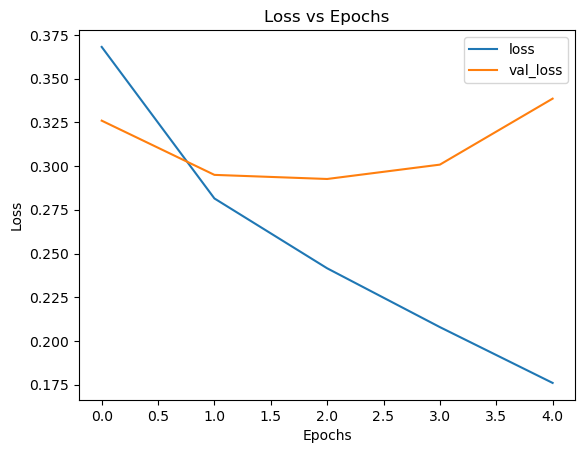

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['loss', 'val_loss'])

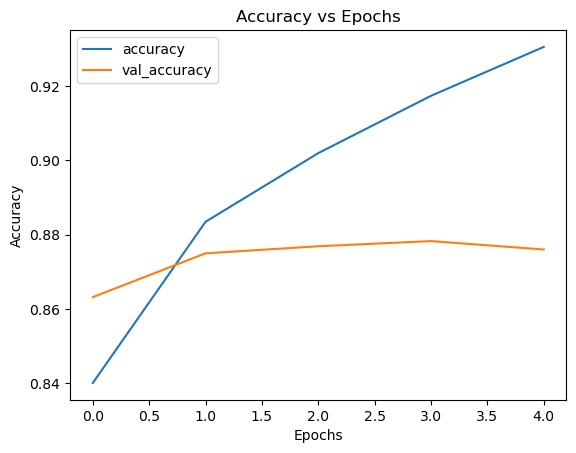

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['accuracy', 'val_accuracy'])